In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import triton
import triton.language as tl
import torch

In [6]:

@triton.autotune(configs=[
    triton.Config({'BLOCK_SIZE_Q': 64, 'BLOCK_SIZE_K': 64}, num_stages=2, num_warps=4),
    #triton.Config({'BLOCK_SIZE_Q': 128, 'BLOCK_SIZE_K': 128}, num_stages=3, num_warps=8),
    #triton.Config({'BLOCK_SIZE_Q': 64, 'BLOCK_SIZE_K': 64}, num_stages=4, num_warps=4),
    #triton.Config({'BLOCK_SIZE_Q': 64, 'BLOCK_SIZE_K': 128}, num_stages=3, num_warps=8),
],
key=['seq_len', 'head_dim']) 
@triton.jit
def flash_attn_kernel(Q,K,V,O,scale:tl.constexpr,
                      LOG_SUM_EXP,
                      q_stride_b,q_stride_nh,q_stride_seq_len,q_stride_head_dim,
                      k_stride_b,k_stride_nh,k_stride_seq_len,k_stride_head_dim,
                      v_stride_b,v_stride_nh,v_stride_seq_len,v_stride_head_dim,
                      o_stride_b,o_stride_nh,o_stride_seq_len,o_stride_head_dim,
                      log_stride_b,log_stride_nh,log_stride_seq_len,
                      bs,nh:tl.constexpr,seq_len:tl.constexpr,head_dim:tl.constexpr,
                      BLOCK_SIZE_Q:tl.constexpr,
                      BLOCK_SIZE_K:tl.constexpr 
                     ):
    pid_q = tl.program_id(0)
    pid_bs_nh = tl.program_id(1)
    batch_index = pid_bs_nh //nh
    head_index  = pid_bs_nh % nh
    Q += batch_index * q_stride_b + head_index * q_stride_nh
    K += batch_index * k_stride_b + head_index * k_stride_nh
    V += batch_index * v_stride_b + head_index * v_stride_nh
    O += batch_index * o_stride_b + head_index * o_stride_nh
    
    LOG_SUM_EXP += batch_index*log_stride_b + head_index * log_stride_nh

    
    QO_offsets_N = pid_q * BLOCK_SIZE_Q + tl.arange(0,BLOCK_SIZE_Q)
    head_dim_offsets = tl.arange(0,head_dim)
    KV_offsets_N = tl.arange(0,BLOCK_SIZE_K)
    QO_offsets = QO_offsets_N[:,None] * q_stride_seq_len +  head_dim_offsets[None,:] * q_stride_head_dim   #BLOCK_SIZE_Q,head_dim
    mask_QO_N = QO_offsets_N < seq_len

    Q_block = tl.load(Q+QO_offsets,mask=mask_QO_N[:,None],other=0.0)
    m_i = tl.full((BLOCK_SIZE_Q,),value=-float('inf'),dtype=tl.float32)
    l_i = tl.full((BLOCK_SIZE_Q,),value= 0,dtype=tl.float32)
    o_i = tl.full((BLOCK_SIZE_Q,head_dim),value=0,dtype=tl.float32)
    

    for k_start in range(0,seq_len,BLOCK_SIZE_K):
        KV_offsets_load = k_start + KV_offsets_N
        KV_offsets_block = head_dim_offsets[:,None]* k_stride_head_dim +  KV_offsets_load[None,:] * k_stride_seq_len #HEAD_DIM,BLOCK_SIZE_K
        k_mask = KV_offsets_load < seq_len  #BLOCK_SIZE_K
        K_block  = tl.load(K+KV_offsets_block,mask=k_mask[None,:],other=0.0)
        
       
        block_scores = tl.dot(Q_block,K_block,out_dtype=tl.float32) * scale #BLOCK_SIZE_Q,BLOCK_SIZE_K
        causal_mask = QO_offsets_N[:,None] >= KV_offsets_load[None,:]
        block_scores = tl.where(k_mask[None, :] & causal_mask, block_scores, float('-inf'))
        
        curr_max  = tl.max(block_scores,axis=1) #BLOCK_SIZE,Q
        m_new = tl.maximum(curr_max,m_i) #BLOCK_SIZE_Q

        p = tl.exp(block_scores - m_new[:,None]) 
        alpha = tl.exp(m_i-m_new) #BLOCK_SIZE_Q
        

        
        l_i = l_i * alpha + tl.sum(p,axis=1) #BLOCK_SIZE_Q
        
        V_offsets_block = KV_offsets_load[:,None] * v_stride_seq_len + v_stride_head_dim * head_dim_offsets[None,:]
        V_block = tl.load(V+V_offsets_block,mask=k_mask[:,None],other=0.0)

        o_i = alpha[:, None] * o_i + tl.dot(p,V_block)
        m_i = m_new 
    
    o_i = o_i / l_i[:,None]
    log_sum_data = tl.log(l_i) + m_i
    
    tl.store(LOG_SUM_EXP+QO_offsets_N,log_sum_data,mask=mask_QO_N)
    tl.store(O + QO_offsets, o_i, mask=mask_QO_N[:, None])



@triton.autotune(configs=[
    triton.Config({'BLOCK_SIZE_DO': 64}, num_stages=2, num_warps=4),
],
key=['head_dim']) 
@triton.jit
def compute_d(Output_ptr,Doutput_ptr,D_ptr,
             output_stride_bs,output_stride_nh,output_stride_seq_len,output_stride_head_dim,
             d_output_stride_bs,d_output_stride_nh,d_output_stride_seq_len,d_output_stride_head_dim,
             d_stride_bs,d_stride_nh,d_stride_seq_len,d_stride_head_dim,
             bs,nh:tl.constexpr,seq_len:tl.constexpr,head_dim:tl.constexpr,
             BLOCK_SIZE_DO:tl.constexpr,  
             ):
    p_id_block_do = tl.program_id(0)
    pid_bs_nh = tl.program_id(1)
    batch_index = pid_bs_nh //nh
    head_index  = pid_bs_nh % nh
    Output_ptr += batch_index*output_stride_bs + head_index * output_stride_nh
    Doutput_ptr +=  batch_index* d_output_stride_bs + head_index * d_output_stride_nh
    block_offsets_seq_len = p_id_block_do * BLOCK_SIZE_DO + tl.arange(0,BLOCK_SIZE_DO)
    head_offsets = tl.arange(0,head_dim) 
    block_ptr = block_offsets_seq_len[:,None] * output_stride_seq_len + head_offsets[None,:] * output_stride_head_dim
    mask_seq_len = block_offsets_seq_len< seq_len
    output_data = tl.load(Output_ptr+block_ptr,mask=mask_seq_len[:,None],other=0.0)
    do_output_data = tl.load(Doutput_ptr+block_ptr,mask=mask_seq_len[:,None],other=0.0)
    
    d_output = tl.sum(output_data*do_output_data,axis=1) #bs,nh,seq_len
    D_ptr += batch_index * d_stride_bs + head_index * d_stride_nh
    d_store_offsets = block_offsets_seq_len * d_stride_seq_len
    tl.store(D_ptr+d_store_offsets,d_output,mask=mask_seq_len)


@triton.autotune(configs=[
    triton.Config({'BLOCK_SIZE_KV': 64,"BLOCK_SIZE_Q":64}, num_stages=2, num_warps=4),
],
key=['head_dim']) 
@triton.jit
def dk_dv_kernel(Q_ptr,K_ptr,V_ptr,DO_ptr,DK_ptr,DV_ptr,LSE_ptr,D_ptr,scale,
                q_stride_b,q_stride_nh,q_stride_seq_len,q_stride_head_dim,
                k_stride_b,k_stride_nh,k_stride_seq_len,k_stride_head_dim,
                v_stride_b,v_stride_nh,v_stride_seq_len,v_stride_head_dim,
                d_o_stride_b,d_o_stride_nh,d_o_stride_seq_len,d_o_stride_head_dim,
                d_k_stride_b,d_k_stride_nh,d_k_stride_seq_len,d_k_stride_head_dim,
                d_v_stride_b,d_v_stride_nh,d_v_stride_seq_len,d_v_stride_head_dim,
                lse_stride_b,lse_stride_nh,lse_stride_seq_len,
                d_stride_b,d_stride_nh,d_stride_seq_len,
                bs,nh,seq_len,head_dim,BLOCK_SIZE_KV:tl.constexpr,BLOCK_SIZE_Q:tl.constexpr):
    
    pid_kv_block = tl.program_id(0)
    pid_bs_nh = tl.program_id(1)
    batch_index = pid_bs_nh //nh
    head_index  = pid_bs_nh % nh
    Q_ptr += q_stride_b * batch_index + q_stride_nh * head_index 
    K_ptr += k_stride_b * batch_index + k_stride_nh * head_index 
    V_ptr += v_stride_b * batch_index + v_stride_nh * head_index 
    DO_ptr += d_o_stride_b* batch_index + d_o_stride_nh * head_index 
    DK_ptr += d_k_stride_b* batch_index + d_k_stride_nh * head_index 
    DV_ptr += d_v_stride_b * batch_index + d_v_stride_nh * head_index 
    LSE_ptr += lse_stride_b * batch_index + lse_stride_nh * head_index 
    D_ptr += d_stride_b * batch_index + d_stride_nh * head_index 
    kv_offsets_seq_len = pid_kv_block * BLOCK_SIZE_KV + tl.arange(0,BLOCK_SIZE_KV)
    head_offsets = tl.arange(0,head_dim)
    kv_block_k =  head_offsets[:,None]* k_stride_head_dim + kv_offsets_seq_len[None,:] * k_stride_seq_len
    kv_block_v = kv_offsets_seq_len[:,None] * v_stride_seq_len + head_offsets[None,:]* v_stride_head_dim
    mask_seq_len = kv_offsets_seq_len < seq_len
    k_block = tl.load(K_ptr+kv_block_k,mask=mask_seq_len[None,:],other=0.0)
    v_block = tl.load(V_ptr+kv_block_v,mask=mask_seq_len[:,None],other=0.0)

    dk_block  = tl.zeros((BLOCK_SIZE_KV,head_dim),dtype=tl.float32)
    dv_block  = tl.zeros((BLOCK_SIZE_KV,head_dim),dtype=tl.float32)

    for q_start in range(0,seq_len,BLOCK_SIZE_Q):
        q_offsets_seq_len = q_start + tl.arange(0,BLOCK_SIZE_Q)
        q_block_ptr = q_offsets_seq_len[:,None] * q_stride_seq_len + head_offsets[None,:] * q_stride_head_dim
        do_block_ptr = q_offsets_seq_len[:,None] * d_o_stride_seq_len + head_offsets[None,:] * d_o_stride_head_dim
        mask_q_seq_len = q_offsets_seq_len<seq_len 
        q_block = tl.load(Q_ptr+q_block_ptr,mask=mask_q_seq_len[:,None],other=0.0)
        do_block = tl.load(DO_ptr+do_block_ptr,mask=mask_q_seq_len[:,None],other=0.0)
        lse = tl.load(LSE_ptr+q_offsets_seq_len*lse_stride_seq_len,mask=mask_q_seq_len,other=0.0)
        d_block = tl.load(D_ptr+q_offsets_seq_len*d_stride_seq_len,mask=mask_q_seq_len,other=0.0)
        S = tl.dot(q_block,k_block) * scale
        P = tl.exp(S-lse[:,None])
        causal_mask = q_offsets_seq_len[:,None] >= kv_offsets_seq_len[None,:]
        P = tl.where(causal_mask,P,0.0)
        dv_block += tl.dot(tl.trans(P),do_block)
        dp  = tl.dot(do_block,tl.trans(v_block))
        ds = P * (dp-d_block[:,None])
        dk_block += tl.dot(tl.trans(ds),q_block) * scale 

    dk_store_ptr = kv_block_v
    tl.store(DK_ptr + dk_store_ptr, dk_block, mask=mask_seq_len[:,None])
    dv_store_ptr = kv_block_v
    tl.store(DV_ptr + dv_store_ptr, dv_block, mask=mask_seq_len[:,None])


@triton.autotune(configs=[
    triton.Config({"BLOCK_SIZE_Q":64,'BLOCK_SIZE_KV': 64,}, num_stages=2, num_warps=4),
],
key=['head_dim']) 
@triton.jit
def do_kernel(Q_ptr,K_ptr,V_ptr,DO_ptr,DQ_ptr,LSE_ptr,D_ptr,scale,
                q_stride_b,q_stride_nh,q_stride_seq_len,q_stride_head_dim,
                k_stride_b,k_stride_nh,k_stride_seq_len,k_stride_head_dim,
                v_stride_b,v_stride_nh,v_stride_seq_len,v_stride_head_dim,
                d_o_stride_b,d_o_stride_nh,d_o_stride_seq_len,d_o_stride_head_dim,
                d_q_stride_b,d_q_stride_nh,d_q_stride_seq_len,d_q_stride_head_dim,
                lse_stride_b,lse_stride_nh,lse_stride_seq_len,
                d_stride_b,d_stride_nh,d_stride_seq_len,
                bs,nh,seq_len,head_dim,BLOCK_SIZE_KV:tl.constexpr,BLOCK_SIZE_Q:tl.constexpr):
    pid_q_block = tl.program_id(0)
    pid_bs_nh = tl.program_id(1)
    batch_index = pid_bs_nh //nh
    head_index  = pid_bs_nh % nh
    Q_ptr += q_stride_b * batch_index + q_stride_nh * head_index 
    K_ptr += k_stride_b * batch_index + k_stride_nh * head_index 
    V_ptr += v_stride_b * batch_index + v_stride_nh * head_index 
    DO_ptr += d_o_stride_b* batch_index + d_o_stride_nh * head_index 
    DQ_ptr += d_q_stride_b* batch_index + d_q_stride_nh * head_index 
    LSE_ptr += lse_stride_b * batch_index + lse_stride_nh * head_index 
    D_ptr += d_stride_b * batch_index + d_stride_nh * head_index 
    q_offsets_seq_len = pid_q_block * BLOCK_SIZE_Q + tl.arange(0,BLOCK_SIZE_Q)
    head_offsets = tl.arange(0,head_dim)
    mask_q_seq_len = q_offsets_seq_len < seq_len 
    q_block_ptr = q_offsets_seq_len[:,None] * q_stride_seq_len + head_offsets[None,:] * q_stride_head_dim # BLOCK_SIZE_Q,HEAD_DIM
    q_data = tl.load(Q_ptr+q_block_ptr,mask=mask_q_seq_len[:,None],other=0.0)
    lse_data = tl.load(LSE_ptr+q_offsets_seq_len*lse_stride_seq_len,mask=mask_q_seq_len,other=0.0)
    d_data = tl.load(D_ptr+q_offsets_seq_len*d_stride_seq_len,mask=mask_q_seq_len,other=0.0) #BLOCK_SIZE_Q
    do_data = tl.load(DO_ptr+q_block_ptr,mask=mask_q_seq_len[:,None],other=0.0) #BLOCK_SIZE_Q,head_dim
    dq_block = tl.zeros((BLOCK_SIZE_Q,head_dim),dtype=tl.float32)

    for k_start in range(0,seq_len,BLOCK_SIZE_KV):
        kv_offsets_seq_len = k_start + tl.arange(0,BLOCK_SIZE_KV)
        mask_kv_seq_len = kv_offsets_seq_len<seq_len
        k_block_ptr = head_offsets[:,None] * k_stride_head_dim + kv_offsets_seq_len[None,:] * k_stride_seq_len
        v_block_ptr  = kv_offsets_seq_len[:,None] * v_stride_seq_len + head_offsets[None,:] * v_stride_head_dim
        k_data = tl.load(K_ptr+k_block_ptr,mask=mask_kv_seq_len[None,:],other=0.0)
        v_data = tl.load(V_ptr+v_block_ptr,mask=mask_kv_seq_len[:,None],other=0.0)

        s = tl.dot(q_data,k_data) * scale #block_size_q,block_size_kv
        p = tl.exp(s-lse_data[:,None])
        causal_mask = q_offsets_seq_len[:,None] >= kv_offsets_seq_len[None,:] #[[0],[1]] [[0,1..63]]
        p = tl.where(causal_mask,p,0.0)
        dp = tl.dot(do_data,tl.trans(v_data)) #BLOCK_SIZE_Q,head_dim , head_dim,BLOCK_SIZE_KV  - BLOCK_SIZE_Q,BLOCK_SIZE_KV
        ds = p * (dp-d_data[:,None]) # BLOCK_SIZE_Q,BLOCK_SIZE_KV * [BLOCK_SIZE_Q,BLOCK_SIZE_KV - BLOCK_SIZE_Q,1] = BLOCK_SIZE_Q,BLOCK_SIZE_KV
        dq = tl.dot(ds,tl.trans(k_data)) * scale  #BLOCK_SIZE_Q,BLOCK_SIZE_KV, BLOCK_SIZE_KV,HEAD_DIM
        dq_block+=dq
    
    tl.store(DQ_ptr + q_block_ptr, dq_block, mask=mask_q_seq_len[:,None])

In [57]:
import math



def test_fla(Q,K,V):
     bs,nh,seq_len,head_dim = Q.shape
     O = torch.empty_like(Q,device='cuda')
     log_sum_exp = torch.empty((bs,nh,seq_len),device='cuda')
     scale = 1/math.sqrt(head_dim)
     grid = lambda args: (
         triton.cdiv(seq_len,args['BLOCK_SIZE_Q']),
         bs*nh,
     )
     flash_attn_kernel[grid](
         Q,K,V,O,scale,
         log_sum_exp,
         Q.stride(0),Q.stride(1),Q.stride(2),Q.stride(3),
         K.stride(0),K.stride(1),K.stride(2),K.stride(3),
         V.stride(0),V.stride(1),V.stride(2),V.stride(3),
         O.stride(0),O.stride(1),O.stride(2),O.stride(3),
         log_sum_exp.stride(0),log_sum_exp.stride(1),log_sum_exp.stride(2),
         bs,nh,seq_len,head_dim
         
     )
     return O,log_sum_exp


    
    

In [58]:
Q = torch.randn(1,8,128,64,dtype=torch.float32,device='cuda',requires_grad=True)
K = torch.randn(1,8,128,64,dtype=torch.float32,device='cuda',requires_grad=True)
V = torch.randn(1,8,128,64,dtype=torch.float32,device='cuda',requires_grad=True)

In [20]:
bench = triton.testing.Benchmark(
    x_names=['seq_len'],
    x_vals=[128, 256, 512, 1024, 2048,4096,8192],
    line_arg='provider',
    line_vals=['triton', 'torch'],
    line_names=['Triton', 'Torch SDPA'],
    plot_name='flash-attention',
    args=dict(head_dim=64),
    xlabel='Sequence Length',
    ylabel='TFLOPS'
)


In [21]:
@triton.testing.perf_report(bench)
def run(seq_len,head_dim,provider):
    return flash_bench(seq_len,head_dim,provider)


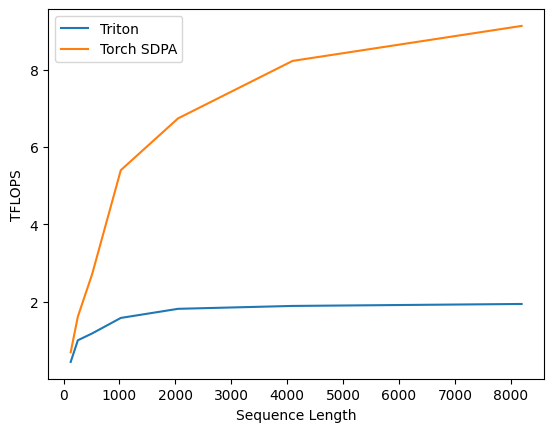

In [22]:
run.run()